In [1]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%load_ext tensorboard
%tensorflow_version 2.x
import tensorflow as tf 
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

TensorFlow 2.x selected.
2.1.0


# Nearest Classifier with feature extraction

**Objectif :** Find the class in function of the distance between features


# Import data

Data from my google drive. Then unzip.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/Data/VET2.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
FOLDER_PATH = "vet2/"

TRAIN_DATA_PATH = FOLDER_PATH + "train/"
TEST_DATA_PATH = FOLDER_PATH + "train/"
VALID_DATA_PATH = FOLDER_PATH + "valid/"

BATCH_SIZE = 128
TARGET_SIZE = (224, 224)

In [0]:
def imshow(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

# Keras image genrator

Simple generator without data augmentation. It is possible to make new image with it however it will increase the number of vectors to compare.

Found 3467 images belonging to 8 classes.
Found 382 images belonging to 8 classes.
[1. 0. 0. 0. 0. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


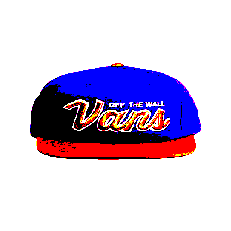

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        target_size=TARGET_SIZE,
        shuffle=False
)

test_generator = test_datagen.flow_from_directory(
        directory=VALID_DATA_PATH,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        target_size=TARGET_SIZE,
        shuffle=False
    )

print(train_generator[0][1][0])
imshow(train_generator[0][0][0])

# Model

The model is built then we predict with whole data (train and test) to get features with shape (7, 7, 512)

In [0]:
model_headless = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [0]:
X_train = model_headless.predict(train_generator)
X_test = model_headless.predict(test_generator)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = train_generator.labels
y_test = test_generator.labels

# Test performaces

We put train features in a K-NN. Then we seach the 1-NN, its label is the prediction for the input sample.

* L2
* L1
* Cosine
* PCA + L2

In [16]:
nn = NearestNeighbors(n_neighbors=3, algorithm="brute")
nn.fit(X_train)
nearst_pred = nn.kneighbors(X_test, return_distance=False, n_neighbors=1)
y_pred = y_train[nearst_pred[:, 0]]
print(accuracy_score(y_test, y_pred))

0.900523560209424


In [17]:
nn = NearestNeighbors(n_neighbors=3, p=1, algorithm="brute")
nn.fit(X_train)
nearst_pred = nn.kneighbors(X_test, return_distance=False, n_neighbors=1)
y_pred = y_train[nearst_pred[:, 0]]
print(accuracy_score(y_test, y_pred))

0.8638743455497382


In [18]:
nn = NearestNeighbors(n_neighbors=3, metric="cosine", algorithm="brute")
nn.fit(X_train)
nearst_pred = nn.kneighbors(X_test, return_distance=False, n_neighbors=1)
y_pred = y_train[nearst_pred[:, 0]]
print(accuracy_score(y_test, y_pred))

0.9057591623036649


In [19]:
pca = PCA(n_components=100)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.transform(X_test)

nn = NearestNeighbors(n_neighbors=3, algorithm="brute")
nn.fit(X_train_red)
nearst_pred = nn.kneighbors(X_test_red, return_distance=False, n_neighbors=1)
y_pred = y_train[nearst_pred[:, 0]]
print(accuracy_score(y_test, y_pred))

0.9083769633507853


# Where are images ?

For image plotting : [reference code function](https://stackoverflow.com/a/638443)


In [0]:
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [0]:
model = vgg16.VGG16(weights='imagenet', input_shape=(224, 224, 3))
X_train_vgg = model.predict(train_generator)

pca = PCA(n_components=2)
X_train_red = pca.fit_transform(X_train_vgg)

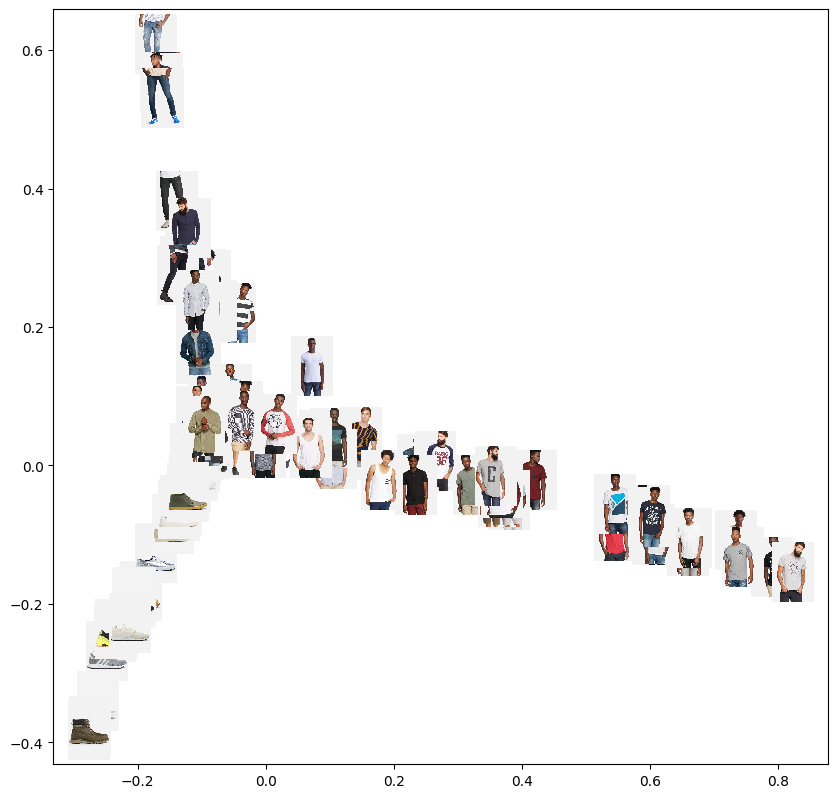

In [15]:
random_idx = np.random.randint(X_train_red.shape[0], size=100)
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
for idx in random_idx:
    imscatter(*X_train_red[idx], train_generator.filepaths[idx], zoom=0.1, ax=ax)